In [1]:
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
from torchvision.transforms import functional as F
from torchvision import transforms, models
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet

In [2]:
# Paths to JSON files and data directory
train_json_path = 'G:/food-101.zip/food-101/meta/train.json'
test_json_path = 'G:/food-101.zip/food-101/meta/test.json'
data_dir = 'G:/food-101.zip/food-101/images'

In [3]:
print("Loading JSON files...")
# Load JSON files
with open(train_json_path, 'r') as f:
    train_data = json.load(f)
with open(test_json_path, 'r') as f:
    test_data = json.load(f)

Loading JSON files...


In [4]:
print("Splitting train data into training and validation sets...")
# Split train data into train and validation
train_data_split = {}
val_data_split = {}

for cls, items in train_data.items():
    train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)
    train_data_split[cls] = train_items
    val_data_split[cls] = val_items

Splitting train data into training and validation sets...


In [5]:
# Create custom dataset class
class FoodDataset(DatasetFolder):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.classes = list(self.data.keys())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = [(os.path.join(self.root_dir, item + ".jpg"), self.class_to_idx[cls])
                        for cls, items in self.data.items() for item in items]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:  # Check if the image has 1 channel
            image = image.repeat(3, 1, 1)  # Convert 1-channel image to 3-channel
        if self.transform:
            image = F.to_pil_image(image)
            image = self.transform(image)
        return image, label

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
print("Initializing datasets and dataloaders...")
# Initialize datasets and dataloaders
train_dataset = FoodDataset(data=train_data_split, root_dir=data_dir, transform=transform)
val_dataset = FoodDataset(data=val_data_split, root_dir=data_dir, transform=transform)
test_dataset = FoodDataset(data=test_data, root_dir=data_dir, transform=transform)

Initializing datasets and dataloaders...


In [8]:
# Use a small subset of the dataset for initial testing
def get_subset(dataset, fraction=0.1):
    num_samples = int(len(dataset) * fraction)
    subset_indices = random.sample(range(len(dataset)), num_samples)
    return Subset(dataset, subset_indices)

train_subset = get_subset(train_dataset, fraction=0.1)
val_subset = get_subset(val_dataset, fraction=0.1)
test_subset = get_subset(test_dataset, fraction=0.1)

print(f"Number of training images: {len(train_subset)}")
print(f"Number of validation images: {len(val_subset)}")
print(f"Number of testing images: {len(test_subset)}")

Number of training images: 6060
Number of validation images: 1515
Number of testing images: 2525


In [9]:
batch_size = 2048
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [10]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# print("Loading pre-trained ResNet18 model...")
# model = models.resnet18(pretrained=True)
# print("Loading pre-trained EfficientNet B7 model...")
# model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=101)
# # num_ftrs = model.fc.in_features
# num_ftrs = model._fc.in_features  # or model._classifier.in_features

# model.fc = nn.Linear(num_ftrs, 101)  # 101 classes
# model = model.to(device)



print("Loading pre-trained ResNet18 model...")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)  # 101 classes
model = model.to(device)

Using device: cuda
Loading pre-trained ResNet18 model...


C:\Users\xtanv\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\xtanv\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# def prune_layer(layer, pruning_rate):
#     """Prunes the given layer by setting a percentage of its weights to zero."""
#     print(f"Pruning layer with pruning rate: {pruning_rate}")
#     with torch.no_grad():
#         weight = layer.weight.data.abs().clone()
#         threshold = torch.quantile(weight, pruning_rate)
#         mask = weight.ge(threshold).float()
#         layer.weight.data.mul_(mask)
#         return mask

In [13]:
# def prune_layer(layer, pruning_rate):
#     """Prunes the given layer by setting a percentage of its weights to zero."""
#     print(f"Pruning layer with pruning rate: {pruning_rate}")
#     with torch.no_grad():
#         weight = layer.weight.data.abs().clone()
#         threshold = torch.quantile(weight, pruning_rate)
#         mask = weight.ge(threshold).float()
#         layer.weight.data.mul_(mask)
#         return mask.clone().detach()  # Return a copy of the mask tensor

In [14]:
# def prune_layer(layer, pruning_rate):
#     """Prunes the given layer by setting a percentage of its weights to zero."""
#     print(f"Pruning layer with pruning rate: {pruning_rate}")
#     with torch.no_grad():
#         weight = layer.weight.data.abs().clone()
#         threshold = torch.quantile(weight, pruning_rate)
#         mask = weight.ge(threshold).float()
#         layer.weight.data.mul_(mask)
#         return torch.tensor(mask, dtype=torch.float32)  # Convert mask to tensor explicitly

In [15]:
def prune_layer(layer, pruning_rate):
    """Prunes the given layer by setting a percentage of its weights to zero."""
    print(f"Pruning layer with pruning rate: {pruning_rate}")
    with torch.no_grad():
        weight = layer.weight.data.abs().clone()
        threshold = torch.quantile(weight, pruning_rate)
        mask = weight.ge(threshold).float()
        layer.weight.data.mul_(mask)
        # print(f"Mask type: {type(mask)}")
        # print(f"Mask value: {mask}")
        return mask

In [16]:
# def fine_tune_model(model, train_loader, criterion, optimizer, num_epochs):
#     """Fine-tunes the model after pruning."""
#     print("Starting fine-tuning...")
#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch + 1}/{num_epochs}")
#         running_loss = 0.0
#         train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
#         for inputs, labels in train_loader_tqdm:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
#         epoch_loss = running_loss / len(train_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

In [17]:
pruning_rates_log = []

def fine_tune_model(model, train_loader, criterion, optimizer, num_epochs):
    """Fine-tunes the model after pruning."""
    print("Starting fine-tuning...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

        # # Append loss to log
        # loss_log.append(epoch_loss)
        
        # # Log pruning rates after each epoch
        # # epoch_pruning_rates = {name: float(mask.sum()) / float(mask.numel()) for name, mask in pruning_rates.items()}
        # # pruning_rates_log.append(epoch_pruning_rates)

        # # Log pruning rates after each epoch
        # epoch_pruning_rates = {}
        # for name, mask in pruning_rates.items():
        #     print(f"Mask type for {name}: {type(mask)}")
        #     epoch_pruning_rates[name] = float(torch.tensor(mask).sum()) / float(mask.numel())
        # pruning_rates_log.append(epoch_pruning_rates)
        
        # # Append loss to log
        # loss_log.append(epoch_loss)
        
        # # Log pruning rates after each epoch
        # pruning_rates_log.append({name: float(mask.sum()) / float(mask.numel()) for name, mask in pruning_rates.items()})

In [18]:
def layer_sensitivity_analysis(model, data_loader, criterion):
    """Performs sensitivity analysis for each layer."""
    print("Starting layer sensitivity analysis...")
    sensitivities = {}
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            print(f"Analyzing layer: {name}")
            initial_loss = evaluate_model(model, data_loader, criterion)
            mask = prune_layer(layer, 0.1)  # Prune 10% as a test
            new_loss = evaluate_model(model, data_loader, criterion)
            sensitivities[name] = new_loss - initial_loss
            layer.weight.data.mul_(mask)  # Revert pruning
            print(f"Sensitivity for layer {name}: {sensitivities[name]}")
    return sensitivities

In [19]:
def evaluate_model(model, data_loader, criterion):
    """Evaluates the model performance."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating model", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    accuracy = 100 * total_correct / total_samples
    print(f"Validation Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    return average_loss

In [20]:
print("Performing sensitivity analysis...")
# Perform sensitivity analysis
sensitivities = layer_sensitivity_analysis(model, val_loader, criterion)

Performing sensitivity analysis...
Starting layer sensitivity analysis...
Analyzing layer: conv1


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Sensitivity for layer conv1: 0.0
Analyzing layer: layer1.0.conv1


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Sensitivity for layer layer1.0.conv1: 0.0
Analyzing layer: layer1.0.conv2


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7979, Validation Accuracy: 1.25%
Sensitivity for layer layer1.0.conv2: 3.147125244140625e-05
Analyzing layer: layer1.1.conv1


Validation Loss: 4.7979, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7980, Validation Accuracy: 1.32%
Sensitivity for layer layer1.1.conv1: 6.437301635742188e-05
Analyzing layer: layer1.1.conv2


Validation Loss: 4.7980, Validation Accuracy: 1.32%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Sensitivity for layer layer1.1.conv2: -7.152557373046875e-05
Analyzing layer: layer2.0.conv1


Validation Loss: 4.7979, Validation Accuracy: 1.32%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7979, Validation Accuracy: 1.25%
Sensitivity for layer layer2.0.conv1: -7.963180541992188e-05
Analyzing layer: layer2.0.conv2


Validation Loss: 4.7979, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7975, Validation Accuracy: 1.25%
Sensitivity for layer layer2.0.conv2: -0.0003376007080078125
Analyzing layer: layer2.0.downsample.0


Validation Loss: 4.7975, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Sensitivity for layer layer2.0.downsample.0: 0.0001010894775390625
Analyzing layer: layer2.1.conv1


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7974, Validation Accuracy: 1.25%
Sensitivity for layer layer2.1.conv1: -0.00021266937255859375
Analyzing layer: layer2.1.conv2


Validation Loss: 4.7974, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7972, Validation Accuracy: 1.25%
Sensitivity for layer layer2.1.conv2: -0.00023746490478515625
Analyzing layer: layer3.0.conv1


Validation Loss: 4.7972, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Sensitivity for layer layer3.0.conv1: 0.0004239082336425781
Analyzing layer: layer3.0.conv2


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Sensitivity for layer layer3.0.conv2: 3.0517578125e-05
Analyzing layer: layer3.0.downsample.0


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7977, Validation Accuracy: 1.25%
Sensitivity for layer layer3.0.downsample.0: 0.00010538101196289062
Analyzing layer: layer3.1.conv1


Validation Loss: 4.7977, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Sensitivity for layer layer3.1.conv1: -0.00011777877807617188
Analyzing layer: layer3.1.conv2


Validation Loss: 4.7976, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7978, Validation Accuracy: 1.25%
Sensitivity for layer layer3.1.conv2: 0.000225067138671875
Analyzing layer: layer4.0.conv1


Validation Loss: 4.7978, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7978, Validation Accuracy: 1.25%
Sensitivity for layer layer4.0.conv1: -5.5789947509765625e-05
Analyzing layer: layer4.0.conv2


Validation Loss: 4.7978, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7980, Validation Accuracy: 1.25%
Sensitivity for layer layer4.0.conv2: 0.00017213821411132812
Analyzing layer: layer4.0.downsample.0


Validation Loss: 4.7980, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7975, Validation Accuracy: 1.25%
Sensitivity for layer layer4.0.downsample.0: -0.00042247772216796875
Analyzing layer: layer4.1.conv1


Validation Loss: 4.7975, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7974, Validation Accuracy: 1.25%
Sensitivity for layer layer4.1.conv1: -8.487701416015625e-05
Analyzing layer: layer4.1.conv2


Validation Loss: 4.7974, Validation Accuracy: 1.25%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.7984, Validation Accuracy: 1.32%
Sensitivity for layer layer4.1.conv2: 0.0009431838989257812
Analyzing layer: fc


Validation Loss: 4.7984, Validation Accuracy: 1.32%
Pruning layer with pruning rate: 0.1


Validation Loss: 4.8004, Validation Accuracy: 1.39%
Sensitivity for layer fc: 0.0019989013671875


In [21]:
# Determine adaptive pruning rates
total_sensitivity = sum(sensitivities.values())
pruning_rates = {name: max(0.0, min(1.0, sens / total_sensitivity)) for name, sens in sensitivities.items()}

print("Applying adaptive pruning...")
# Apply adaptive pruning
for name, layer in model.named_modules():
    if name in pruning_rates:
        prune_layer(layer, pruning_rates[name])


Applying adaptive pruning...
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.012709416522241479
Pruning layer with pruning rate: 0.025996533795493933
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.04082418640477566
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.17119198921625264
Pruning layer with pruning rate: 0.012324282688234161
Pruning layer with pruning rate: 0.04255728865780859
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.09089158482572694
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.06951665703832081
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.0
Pruning layer with pruning rate: 0.380897361833237
Pruning layer with pruning rate: 0.8072405160793376


In [22]:
print("Fine-tuning the pruned model...")
# Fine-tune the pruned model
loss_log = []
pruning_rates_log = []
fine_tune_model(model, train_loader, criterion, optimizer, num_epochs=5)

Fine-tuning the pruned model...
Starting fine-tuning...
Epoch 1/5


Epoch 1/5: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.02s/it, loss=4.66]


Epoch [1/5], Loss: 4.658824284871419
Epoch 2/5


Epoch 2/5: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.98s/it, loss=4.62]


Epoch [2/5], Loss: 4.624129931131999
Epoch 3/5


Epoch 3/5: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.06s/it, loss=4.61]


Epoch [3/5], Loss: 4.613083521525065
Epoch 4/5


Epoch 4/5: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.22s/it, loss=4.61]


Epoch [4/5], Loss: 4.6114433606465655
Epoch 5/5


Epoch 5/5: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.24s/it, loss=4.61]

Epoch [5/5], Loss: 4.609378178914388


In [23]:
print("Saving the pruned and fine-tuned model...")
# Save the model
torch.save(model.state_dict(), 'food101_Res18_pruned.pth')

Saving the pruned and fine-tuned model...


Evaluating the final model on the test set...


Testing model: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.08s/it]


Test Accuracy: 1.07%


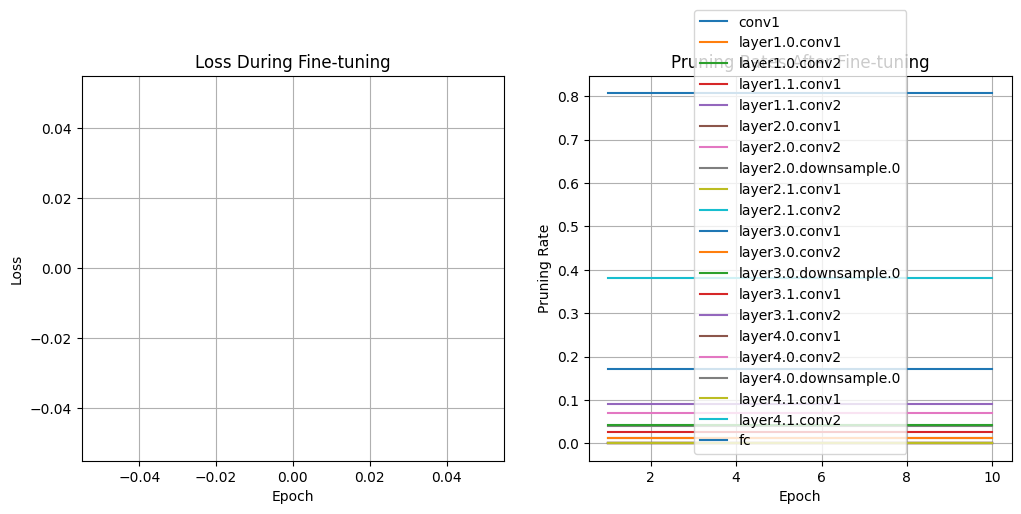

In [24]:
print("Evaluating the final model on the test set...")
# Evaluate the final model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing model"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting the loss log and pruning rates log
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_log) + 1), loss_log, marker='o')
plt.title('Loss During Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
for name, rate in pruning_rates.items():
    plt.plot(range(1, 11), [rate] * 10, label=name)
plt.title('Pruning Rates After Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Pruning Rate')
plt.legend()
plt.grid(True)
plt.show()